Text(0, 0.5, 'Excess Return')

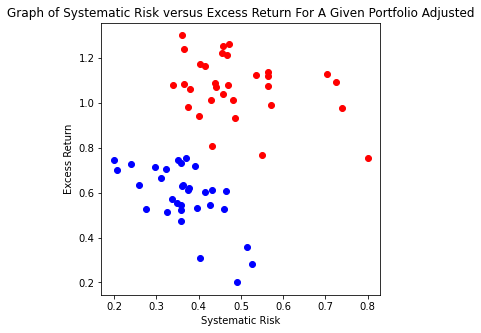

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt 
import pandas as pd 
from numpy.linalg import inv 
import csv 

'''
Have to do some data preprocessing to obtain our data 
'''
df = pd.read_csv('Stonk.csv')

data = list(df.to_numpy())

n = len(data)
systematic_risk = []
excess_return = []

#this is our binary parameter 
classifier = [] 

for i in range(0,n):
    systematic_risk.append(float(data[i][6])) 
    excess_return.append(float(data[i][5]))

    if (data[i][3] == 0):
        classifier.append(-1)
        excess_return[i] += 0.5 #make a slight adjustment to make the data easier to classify 
    else: 
        classifier.append(1) 

# print(systematic_risk)
# print(excess_return) 
# print(classifier) 

plt.figure(figsize = (5, 5))
for i in range(0,n):
    if (classifier[i] == 1): 
        plt.scatter(systematic_risk[i],excess_return[i],c='b')
    else: 
        plt.scatter(systematic_risk[i],excess_return[i],c='r')
        
plt.title("Graph of Systematic Risk versus Excess Return For A Given Portfolio Adjusted")
plt.xlabel("Systematic Risk")
plt.ylabel("Excess Return")

In [2]:
'''
Reformulate the data so it can be stuffed into my shitty algorithm 
'''

dataset = [] 
for i in range(0,n): 
    temp = [] 
    temp.append(systematic_risk[i])
    temp.append(excess_return[i])
    dataset.append(temp) 

#Dataset contains the data in the following order: [x coordinate, y coordinate]
#Or it can also be [annual return, total risk] 
#Classifier for each point is in the form dataset[i] = classifier[i] 
print(dataset) 
print(classifier)

[[0.738, 0.978], [0.572, 0.988], [0.703, 1.13], [0.8, 0.756], [0.432, 0.8069999999999999], [0.491, 0.2], [0.36, 1.3], [0.724, 1.0939999999999999], [0.454, 1.221], [0.439, 1.087], [0.564, 1.0739999999999998], [0.563, 1.138], [0.482, 1.0110000000000001], [0.4, 0.9430000000000001], [0.458, 1.0390000000000001], [0.55, 0.766], [0.357, 0.474], [0.374, 0.612], [0.426, 0.544], [0.515, 0.356], [0.403, 0.31], [0.472, 1.26], [0.365, 1.2389999999999999], [0.535, 1.125], [0.467, 1.212], [0.34, 1.081], [0.565, 1.121], [0.379, 1.062], [0.375, 0.982], [0.486, 0.9299999999999999], [0.43, 1.014], [0.2, 0.746], [0.46, 0.525], [0.369, 0.755], [0.325, 0.512], [0.377, 0.621], [0.465, 0.609], [0.348, 0.552], [0.358, 0.524], [0.338, 0.57], [0.525, 0.281], [0.457, 1.2530000000000001], [0.415, 1.165], [0.365, 1.0819999999999999], [0.469, 1.08], [0.44, 1.068], [0.358, 0.732], [0.239, 0.729], [0.432, 0.613], [0.392, 0.718], [0.207, 0.7], [0.415, 0.603], [0.312, 0.665], [0.275, 0.528], [0.396, 0.53], [0.359, 0.544

In [13]:
def u(y,s,A):
    '''
    calculate u, which is our complementary number 
    '''
    m = len(A) 
    numerator = y.T @ s
    return numerator/m

def cost_function(x,Q,c):
    '''
    cost function 
    '''
    return (0.5 * x.T@Q@x + c.T@x)

def diagonalize(x): 
    '''
    turn a vector into a diagonal matrix 
    '''
    d = np.diag(x) 
    return d

def delta_solver1(G0,A0,s0,x0,y0,b0,c0):
    '''
    A delta solver for our problem
    Note: define s_aff0, y_aff0, sigma0, and u0 as equal to 0 for the affine calculation 
    '''
    m = len(A0)
    n = len(A0[0]) 
    
    e = [1] * n 
    s_diag = diagonalize(s0)
    y_diag = diagonalize(y0)

    #define the right side 
    rd = (G0@x0 - A0.T@s0 + c0)
    rp = (A0@x0 - y0 - b0)
    center = s_diag@y_diag@e
    
    joint = np.concatenate((rd,rp,center))
    right = np.tile(joint,(2*m+n,2*m+n))
    
    #define our block matrix left side (holy shit here we go)
    G = G0
    A = A0
    I = np.identity(m) 
    s_diag = diagonalize(s0)
    y_diag = diagonalize(y0)

    left = np.block([[G,np.zeros((n,m)),-A.T],[A, -I, np.zeros((m,m))],[np.zeros((m,n)),s_diag,y_diag]])

    #solve (and hope that matrix isn't singular) 
    result = inv(left)@right
    
    #define the variables that we want to return 
    x_aff = result[0][:n]
    y_aff = result[0][n:2*n]
    s_aff = result[0][2*n:3*n]
    return x_aff,y_aff,s_aff

def delta_solver2(G0,A0,s0,x0,y0,b0,c0,s_aff0,y_aff0,sigma0,u0):
    '''
    A delta solver for our problem
    Note: define s_aff0, y_aff0, sigma0, and u0 as equal to 0 for the affine calculation 
    '''
    m = len(A0)
    n = len(A0[0]) 
    
    e = np.ones(n) 
    s_diag = diagonalize(s0)
    y_diag = diagonalize(y0)
    
    #should be zero for the first calculation
    s_aff_diag = diagonalize(s_aff0) 
    y_aff_diag = diagonalize(y_aff0) 
    
    #define the right side 
    rd = (G0@x0 - A0.T@s0 + c0)
    rp = (A0@x0 - y0 - b0)

    center = s_diag@y_diag@e + s_aff_diag@y_aff_diag@e - sigma0*u0*e
    
    #make some changes to our right matrix
    joint = np.concatenate((rd,rp,center))
    right = np.tile(joint,(2*m+n,2*m+n))
    

    #define our block matrix left side (holy shit here we go)
    G = G0
    A = A0
    I = np.identity(m) 
    s_diag = diagonalize(s0)
    y_diag = diagonalize(y0)

    left = np.block([[G,np.zeros((n,m)),-A.T],[A, -I, np.zeros((m,m))],[np.zeros((m,n)),s_diag,y_diag]])
    
    #solve (and hope that matrix isn't singular) 
    result = inv(left)@right
    
    delta_x = result[0][:n]
    delta_y = result[0][n:2*n]
    delta_s = result[0][2*n:3*n]
    return delta_x,delta_y,delta_s

def find_alpha_aff(y,s,dy_affine,ds_affine):
    '''
    want to find alpha affine for third step 
    y_d and s_d are delta y and delta lambda respectively 
    '''
    n = len(y) 
    m = len(s) 
    iteration = 0 
    alpha = 1
    beta = 0.9 
    maxIter = 1000
    
    while (iteration < maxIter): 
        for i in range(0,n): 
            y_val = y[i]+alpha*dy_affine[i]
            s_val = s[i]+alpha*ds_affine[i]
            if (y_val < 0): 
                alpha = alpha * beta 
                iteration += 1
                break 
            if (s_val < 0): 
                alpha = alpha * beta 
                iteration += 1
                break 
        iteration += 1
    return alpha,iteration
    
def find_alpha_pd(x,dx,tau): 
    '''
    find alpha for primal or dual
    using the same function since they are similar just with different parameters 
    '''
    n = len(x) 
    
    alpha = 1
    beta = 0.9 
    maxIter = 1000
    iteration = 0 
    
    while (iteration < maxIter): 
        for i in range(0,n): 
            right = (1-tau)*x[i]
            left = x[i]+alpha*dx[i]
            if (left < right): 
                alpha = alpha * beta 
                iteration += 1
                break 
        iteration += 1
    return alpha,iteration

def linear_kernel(X,y):
    '''
    Compute dot product between each data point in dataset times classifier value too
    '''
    n = len(X)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i][j] = y[i]*np.dot(X[i][0], X[j][0])*y[j] #calculate the matrix for the Q in the quadratic form problem

    return K

def IPM(Q,c,A,b,x,s): 
    '''
    QP program given Q,A,b,c,x,and s as parameters 
    x is a vector of input values of R^n
    y is the lagrange multiplier associated with the equality constraint Ax = b 
    s is the lagrange multiplier associated with the inequality constraint x >= 0

    Reminder: Quadratic Program is a program that takes the form: 
    min 1/2 * x.T@Q@x + c.T@x
    st Ax >= b 
    c.T, x is in R^n
    b is in R^m 
    A is in R^mxn
    Q is in R^nxn and also positive definite
    
    This is a implementation of the interior point method using nocedal  
    '''
    #initialize our variables 
    k = 0 
    maxIter = 100
    x0 = x
    y0 = A@x0 - b #needs to be positive (should also be a vector)
    s0 = s #needs to be positive 
    alpha = 1
    tol = 1e-4
    
    #this is a tunable parameter for our uk (nocedal said use 0 to start out) 
    sigma = 0
    
    #initialize our iteration variables 
    xk = 0 
    yk = 0
    sk = 0 
    
    while (k < maxIter):
        #step 1 set the last 4 parameters equal to 0 since we don't have them yet
        delta_x_aff, delta_y_aff, delta_lambda_aff = delta_solver1(Q,A,s0,x0,y0,b,c)

        #step 2 (done) 
        u0 = u(y0,s0,A)

        #step 3 (done) 
        alpha_aff,iter1 = find_alpha_aff(y0,s0,delta_y_aff,delta_lambda_aff)

        #step 4 (done) 
        y_temp = (y0 + alpha_aff*delta_y_aff)
        s_temp = (s0 + alpha_aff*delta_lambda_aff) 
        u_aff = u(y_temp,s_temp,A)

        #step5, set centering parameter (done)
        sigma = (u_aff/u0)**3

        #step6, solve 16.67 for deltax, deltay, deltas (done) 
        delta_x,delta_y,delta_lambda = delta_solver2(Q,A,s0,x0,y0,b,c,delta_lambda_aff,delta_y_aff,sigma,u0)
        
        #step 7 (done) 
        tau = 0.5
        alpha_p,iter_p = find_alpha_pd(y0,delta_y,tau)
        alpha_d,iter_d = find_alpha_pd(s0,delta_lambda,tau)  
        alpha = min(alpha_p,alpha_d)
        
        #step 8, set our parameters using iterates we found (done) 
        xk = x0 + alpha*delta_x 
        yk = y0 + alpha*delta_y
        sk = s0 + alpha*delta_lambda
        
        #update our initial values so we can perform iteration again 
        x0,y0,s0 = xk,yk,sk
#         print(iter1)
#         print(iter_p)
#         print(iter_d)
        #increment k by one and continue the iteration 
        k += 1
        
    return xk, yk, sk, k

In [14]:
#Dataset = [[x1,y1],[x2,y2],...]
#Classifier [-1,1,-1,1]

#Define our variables 
Q = linear_kernel(dataset,classifier) #yn*Kernel*ym 
n = len(Q)

A = np.identity(n)
c = -np.ones(n)
x = np.ones(n)
s = np.ones(n)
b = np.zeros(n)

x_opt, y_opt, s_opt, iterations = IPM(Q,c,A,b,x,s) #optimize 
print("optimum x:", x_opt)
print("optimum y:", y_opt)
print("optimum s:", s_opt)
print("Iterations:",iterations)

optimum x: [1.02600438 1.01133371 1.02291118 1.03148373 0.99896071 0.91738442
 0.9925974  1.0247671  1.00090505 0.99957936 1.01062669 1.01053831
 1.00337965 0.99613258 1.00125856 1.00938939 0.92922783 0.92772531
 0.92312937 0.9152632  0.92516219 1.00249587 0.9930393  1.00806372
 1.00205397 0.99082981 1.01071507 0.99427661 0.99392309 1.00373317
 0.99878395 0.94310396 0.92012432 0.92816723 0.9320561  0.92746016
 0.9196824  0.93002328 0.92913945 0.93090712 0.91437936 1.00117018
 0.99745827 0.9930393  1.00223073 0.99966774 0.92913945 0.93965704
 0.92259907 0.92613441 0.94248529 0.92410159 0.93320508 0.93647525
 0.92578088 0.92905107 0.99630934 0.92984652 0.93223286 0.937801
 0.92896268 0.92878592 0.93461921]
optimum y: [1.00014125 1.0000373  1.00011933 1.00018007 0.99994963 0.99937163
 0.99990454 1.00013248 0.9999634  0.99995401 1.00003229 1.00003166
 0.99998094 0.99992959 0.99996591 1.00002352 0.99945555 0.9994449
 0.99941234 0.99935661 0.99942674 0.99997467 0.99990767 1.00001413
 0.99997

In [15]:
#Recover our primal variables 

#x_opt is our optimal lambda value

w_opt = []
b_opt = []
delta_opt = [] 


#recover w (solve the first lagrange equation)
for i in range(0,n): 
    w_opt.append(classifier[i]*x_opt[i]*dataset[i][0]) 
    
#recover b (solve the equation directly) 
#b_opt.append(classifier-np.dot(w_opt,excess_return))
for i in range(n):
    b_opt.append(classifier[i]-w_opt[i]*dataset[i][0])

#recover delta 
for i in range(0,n):
    delta_opt.append(1 - classifier[i]*(x_opt[i]*dataset[i][0]+b_opt[i]))

#print 
print("Optimal w: ", w_opt)
print("Optimal b: ", b_opt)
print("Optimal delta: ", delta_opt)

Optimal w:  [-0.757191232598921, -0.5784828834048631, -0.7191065621719979, -0.825186987365531, -0.4315510268786892, 0.4504357500012984, -0.3573350647242296, -0.7419313823689674, -0.4544108917471611, -0.43881534060396654, -0.5699934515539764, -0.5689330679583011, -0.4836289935642379, -0.3984530309699658, -0.458576422071663, -0.5551641656956217, 0.3317343361368504, 0.3469692675302381, 0.3932531109978844, 0.4713605495383481, 0.3728403634477656, -0.47317804929593416, -0.36245934431527144, -0.5393140888558939, -0.4679592054520992, -0.3368821355735224, -0.5710540119020793, -0.37683083579724225, -0.37272116024394036, -0.48781432039120437, -0.42947709946873747, 0.18862079295169915, 0.42325718747903, 0.3424937084110722, 0.30291823185608807, 0.34965248177856106, 0.42765231663462494, 0.32364810231742003, 0.3326319227194717, 0.3146466050884416, 0.48004916506234235, -0.45753477435837253, -0.41394518020996646, -0.36245934431527144, -0.4700462127261302, -0.4398538067283086, 0.3326319227194717, 0.2245

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Slope: -1.1986143507476918
intercept: 0.9622758414096602
adjustment 0.2627484000405283


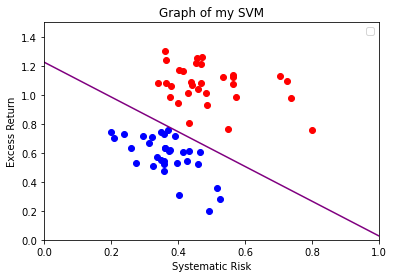

In [20]:
from numpy.linalg import norm

#convert w and b into values we can use 
w_val = 0 
b_val = 0
for i in range(n):
    w_val += w_opt[i]
    b_val += b_opt[i]

#normalize our values and define other parameters accordingly 
b = norm(w_val)
slope = np.dot(w_opt/b,x_opt)
bb = max(b_opt)
adjustment = sum(delta_opt)/len(delta_opt)

#print out our findings!
print("Slope:", slope) 
print("intercept:", bb)
print("adjustment",adjustment)

#calculate my x and y for graphing purposes 
x_lin = np.linspace(0,1,n)
y_fin = slope * x_lin + bb + adjustment

#plot my result 
plt.plot(x_lin, y_fin,c='purple')

for i in range(0,n):
    if (classifier[i] == 1): 
        plt.scatter(systematic_risk[i],excess_return[i],c='b')
    else: 
        plt.scatter(systematic_risk[i],excess_return[i],c='r')
plt.title("Graph of my SVM")
plt.xlabel("Systematic Risk")
plt.ylabel("Excess Return")
plt.xlim(0,1)
plt.ylim(0,1.5)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


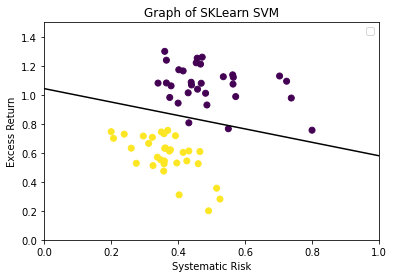

In [17]:
#3 Example from Sklearn 

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

# linear data
X = np.array(systematic_risk)
y = np.array(excess_return)

# shaping data for training the model
training_X = np.vstack((X, y)).T
training_y = np.array(classifier) 

# define the model
clf = svm.SVC(kernel='linear', C=1.0)

# train the model
clf.fit(training_X, training_y)

# get the weight values for the linear equation from the trained SVM model
w = clf.coef_[0]

# get the y-offset for the linear equation
a = -w[0] / w[1]

# make the x-axis space for the data points
XX = np.linspace(0, len(X))

# get the y-values to plot the decision boundary
yy = a * XX - clf.intercept_[0] / w[1]

# plot the decision boundary
plt.plot(XX, yy, 'k-')

# show the plot visually
plt.scatter(training_X[:, 0], training_X[:, 1], c=training_y)
plt.title("Graph of SKLearn SVM")
plt.xlabel("Systematic Risk")
plt.ylabel("Excess Return")
plt.xlim(0,1)
plt.ylim(0,1.5)
plt.legend()
plt.show()